In [1]:
import warnings

import arviz as az
import numpy as np
import pymc3 as pm
import seaborn as sns

from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/home/mwm/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
az.style.use("arviz-darkgrid")
warnings.simplefilter(action="ignore", category=FutureWarning)
RANDOM_SEED = 8924
np.random.seed(3264602)  # from random.org

In [3]:
N = 10000

μ_actual = np.array([1.0, -2.0])
sigmas_actual = np.array([0.7, 1.5])
Rho_actual = np.matrix([[1.0, -0.4], [-0.4, 1.0]])

Σ_actual = np.diag(sigmas_actual) * Rho_actual * np.diag(sigmas_actual)

x = np.random.multivariate_normal(μ_actual, Σ_actual, size=N)
Σ_actual

matrix([[ 0.49, -0.42],
        [-0.42,  2.25]])

In [4]:
var, U = np.linalg.eig(Σ_actual)
angle = 180.0 / np.pi * np.arccos(np.abs(U[0, 0]))

fig, ax = plt.subplots(figsize=(8, 6))

blue, _, red, *_ = sns.color_palette()

e = Ellipse(μ_actual, 2 * np.sqrt(5.991 * var[0]), 2 * np.sqrt(5.991 * var[1]), angle=angle)
e.set_alpha(0.5)
e.set_facecolor(blue)
e.set_zorder(10)
ax.add_artist(e)

ax.scatter(x[:, 0], x[:, 1], c="k", alpha=0.05, zorder=11)

rect = plt.Rectangle((0, 0), 1, 1, fc=blue, alpha=0.5)
ax.legend([rect], ["95% density region"], loc=2);

In [5]:
with pm.Model() as m:
    packed_L = pm.LKJCholeskyCov("packed_L", n=2, eta=2.0, sd_dist=pm.Exponential.dist(1.0))

In [6]:
with m:
    L = pm.expand_packed_triangular(2, packed_L)
    Σ = L.dot(L.T)

L.tag.test_value.shape

(2, 2)

In [9]:
with pm.Model() as model:
    chol, corr, stds = pm.LKJCholeskyCov(
        "chol", n=2, eta=2.0, sd_dist=pm.Exponential.dist(1.0), compute_corr=True
    )
    cov = pm.Deterministic("cov", chol.dot(chol.T))

In [18]:
chol

AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True}.0

In [10]:
with model:
    μ = pm.Normal("μ", 0.0, 1.5, shape=2, testval=x.mean(axis=0))
    obs = pm.MvNormal("obs", μ, chol=chol, observed=x)

In [11]:
with model:
    trace = pm.sample(random_seed=RANDOM_SEED, init="adapt_diag", return_inferencedata=True)
az.summary(trace, var_names=["~chol"], round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, chol]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.
/home/mwm/anaconda3/lib/python3.7/site-packages/arviz/stats/diagnostics.py:642: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
μ[0]            1.02  0.01    1.00     1.03        0.0      0.0   4439.48   
μ[1]           -2.03  0.01   -2.06    -2.01        0.0      0.0   4529.68   
chol_stds[0]    0.69  0.00    0.68     0.70        0.0      0.0   5729.60   
chol_stds[1]    1.50  0.01    1.48     1.52        0.0      0.0   6273.24   
chol_corr[0,0]  1.00  0.00    1.00     1.00        0.0      0.0   4000.00   
chol_corr[0,1] -0.39  0.01   -0.41    -0.38        0.0      0.0   6275.57   
chol_corr[1,0] -0.39  0.01   -0.41    -0.38        0.0      0.0   6275.57   
chol_corr[1,1]  1.00  0.00    1.00     1.00        0.0      0.0   4000.00   
cov[0,0]        0.48  0.01    0.47     0.50        0.0      0.0   5726.52   
cov[0,1]       -0.41  0.01   -0.43    -0.39        0.0      0.0   5710.41   
cov[1,0]       -0.41  0.01   -0.43    -0.39        0.0      0.0   5710.41   
cov[1,1]        2.25  0.03    2.19     2.31        0.0      0.0   6278.49   

                 ess_sd  ess_bulk  ess_tail  r_hat  
μ[0]            4439.22   4395.71   3386.11    1.0  
μ[1]            4529.68   4548.20   3303.89    1.0  
chol_stds[0]    5726.52   5721.91   3097.64    1.0  
chol_stds[1]    6273.24   6260.32   2842.37    1.0  
chol_corr[0,0]  4000.00   4000.00   4000.00    NaN  
chol_corr[0,1]  6275.57   6295.79   3380.56    1.0  
chol_corr[1,0]  6275.57   6295.79   3380.56    1.0  
chol_corr[1,1]  4000.00   3712.55   3567.33    1.0  
cov[0,0]        5718.60   5721.91   3097.64    1.0  
cov[0,1]        5710.41   5706.58   3327.79    1.0  
cov[1,0]        5710.41   5706.58   3327.79    1.0  
cov[1,1]        6278.49   6260.32   2842.37    1.0

In [12]:
az.plot_trace(
    trace,
    var_names=["~chol"],
    compact=True,
    lines=[
        ("μ", {}, μ_actual),
        ("cov", {}, Σ_actual),
        ("chol_stds", {}, sigmas_actual),
        ("chol_corr", {}, Rho_actual),
    ],
);

/home/mwm/anaconda3/lib/python3.7/site-packages/arviz/stats/density_utils.py:248: RuntimeWarning: divide by zero encountered in double_scalars
  t_j = np.power((c1 * (c2 / (N * f))), (2.0 / (3.0 + 2.0 * j)))
/home/mwm/anaconda3/lib/python3.7/site-packages/arviz/stats/density_utils.py:252: RuntimeWarning: divide by zero encountered in double_scalars
  out = t - (2 * N * np.pi ** 0.5 * f) ** (-0.4)
/home/mwm/anaconda3/lib/python3.7/site-packages/arviz/stats/density_utils.py:276: RuntimeWarning: invalid value encountered in double_scalars
  bw = (_bw_silverman(x) / np.ptp(x)) ** 2
/home/mwm/anaconda3/lib/python3.7/site-packages/arviz/stats/density_utils.py:760: RuntimeWarning: invalid value encountered in true_divide
  f = grid_counts / bin_width / len(x)
/home/mwm/anaconda3/lib/python3.7/site-packages/arviz/stats/density_utils.py:770: UserWarning: Something failed when estimating the bandwidth. Please check your data
  warnings.warn("Something failed when estimating the bandwidth. Please

In [13]:
μ_post = trace.posterior["μ"].mean(axis=(0, 1)).data
(1 - μ_post / μ_actual).round(2)

array([-0.02, -0.02])

In [19]:
μ_post

array([ 1.01676037, -2.03195128])

In [14]:
Σ_post = trace.posterior["cov"].mean(axis=(0, 1)).data
(1 - Σ_post / Σ_actual).round(2)

array([[0.02, 0.03],
       [0.03, 0.  ]])

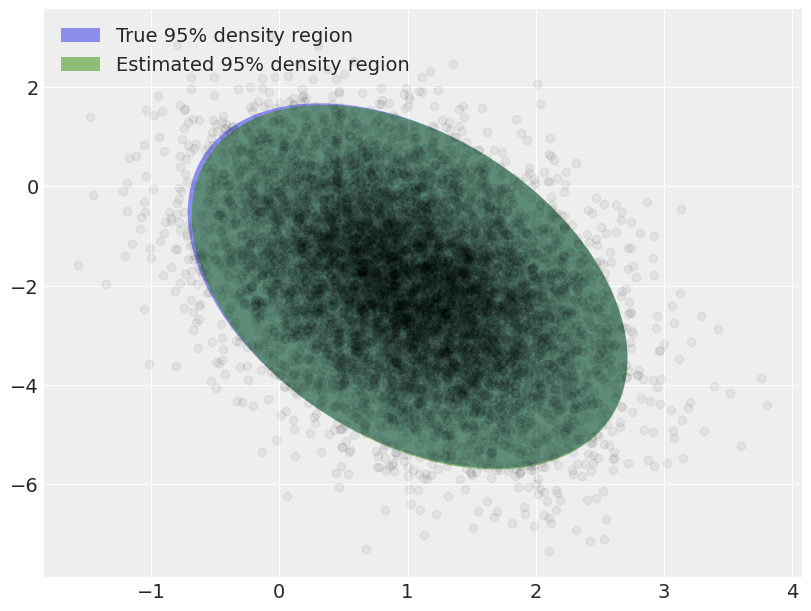

In [15]:
var_post, U_post = np.linalg.eig(Σ_post)
angle_post = 180.0 / np.pi * np.arccos(np.abs(U_post[0, 0]))

fig, ax = plt.subplots(figsize=(8, 6))

e = Ellipse(μ_actual, 2 * np.sqrt(5.991 * var[0]), 2 * np.sqrt(5.991 * var[1]), angle=angle)
e.set_alpha(0.5)
e.set_facecolor(blue)
e.set_zorder(10)
ax.add_artist(e)

e_post = Ellipse(
    μ_post,
    2 * np.sqrt(5.991 * var_post[0]),
    2 * np.sqrt(5.991 * var_post[1]),
    angle=angle_post,
)
e_post.set_alpha(0.5)
e_post.set_facecolor(red)
e_post.set_zorder(10)
ax.add_artist(e_post)

ax.scatter(x[:, 0], x[:, 1], c="k", alpha=0.05, zorder=11)

rect = plt.Rectangle((0, 0), 1, 1, fc=blue, alpha=0.5)
rect_post = plt.Rectangle((0, 0), 1, 1, fc=red, alpha=0.5)
ax.legend(
    [rect, rect_post],
    ["True 95% density region", "Estimated 95% density region"],
    loc=2,
);